In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Add, Layer, Reshape, Multiply
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform



from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [ ]:
#check if tensorflow is built with cuda
import tensorflow as tf
from tensorflow.python.client import device_lib

print(f'Built with cuda: {tf.test.is_built_with_cuda()}' )
print(f'Tensorflow version: {tf.__version__}')
print(device_lib.list_local_devices())

In [2]:
#enable memory growth for gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
class_list = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_count = len(class_list)
image_size = (48, 48)
batch_size = 250

In [4]:
def plot_confusion_matrix(y_true, y_pred_probs, labels):
    
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    #plotting
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xticks(rotation=45)
    ax.invert_xaxis()

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_fuzzy_confusion_matrix(y_true, y_pred_probs):
    #y_true is the true labels
    #y_pred_probs is the resultant softmax probabilities

    cm = np.zeros((class_count, class_count))

    for i in range(y_true.shape[0]):
        #distribute the squared probability of each prediction to the true and predicted labels
        cm[y_true[i]] += y_pred_probs[i]
    
    cm = cm / np.sum(cm, axis=1, keepdims=True)

    #group similar genres together
    similarity_matrix = cm.copy()

    distance_matrix = 1 - similarity_matrix
    np.fill_diagonal(distance_matrix, 0)
    distance_matrix = (distance_matrix + distance_matrix.T) / 2

    #hierarchical clustering
    Y = squareform(distance_matrix, checks=False)
    Z = linkage(Y, method='average')
    optimal_order = leaves_list(Z)

    cm_reordered = cm[optimal_order][:, optimal_order]
    labels_reordered = [class_list[i] for i in optimal_order]

    #plotting
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(cm_reordered, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels_reordered, yticklabels=labels_reordered)
    plt.xticks(rotation=45)
    ax.invert_xaxis()

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Fuzzy Confusion Matrix with Hierarchical Clustering')
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [5]:
dataset_train_base = "/home/qolson/datasets/facial_expression/train/"
dataset_validation_base = "/home/qolson/datasets/facial_expression/validation/"

augmented_train_base = "/home/qolson/datasets/facial_expression/train_aug/"
augmented_validation_base = "/home/qolson/datasets/facial_expression/validation_aug/"

combined_train_base = "/home/qolson/datasets/facial_expression/combined_train/"

In [60]:
#print file counts in each directory
train_class_counts = {emotion: len(os.listdir(dataset_train_base + emotion)) for emotion in class_list}
print("Training set")
for emotion in class_list:
    print(f"{emotion}: {len(os.listdir(dataset_train_base + emotion))}")

print("\nValidation set")
for emotion in class_list:
    print(f"{emotion}: {len(os.listdir(dataset_validation_base + emotion))}")


Training set
angry: 7986
fear: 8206
happy: 14328
neutral: 9964
sad: 9876
surprise: 6410

Validation set
angry: 1920
fear: 2036
happy: 3650
neutral: 2432
sad: 2278
surprise: 770


In [63]:
#augment training set by applying random amounts of rotation, zoom, and horizontal flip
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for emotion in class_list:
    os.makedirs(augmented_train_base + emotion, exist_ok=True)
    for filename in os.listdir(dataset_train_base + emotion):
        img = tf.keras.preprocessing.image.load_img(dataset_train_base + emotion + '/' + filename)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_train_base + emotion, save_prefix=filename, save_format='jpg'):
            i += 1
            if i >= 5:
                break


In [64]:
#print file counts in augmented training set
print("\nAugmented training set")
for emotion in class_list:
    print(f"{emotion}: {len(os.listdir(augmented_train_base + emotion))}")


Augmented training set
angry: 19966
fear: 20511
happy: 35805
neutral: 24902
sad: 24689
surprise: 16023


In [66]:

#combine training set with augmented training set to achieve 22,000 images per class, we will use all the original train images and randomly sample from the augmented images to achieve this

for emotion in class_list:
    print(f"Copying {emotion} images")
    os.makedirs(combined_train_base + emotion, exist_ok=True)
    original_images = os.listdir(dataset_train_base + emotion)
    augmented_images = os.listdir(augmented_train_base + emotion)
    for filename in original_images:
        os.system(f"cp {dataset_train_base + emotion}/{filename} {combined_train_base + emotion}/{filename}")
    for filename in np.random.choice(augmented_images, size=22000-len(original_images), replace=False):
        os.system(f"cp {augmented_train_base + emotion}/{filename} {combined_train_base + emotion}/{filename}")

Copying angry images
Copying fear images
Copying happy images
Copying neutral images
Copying sad images
Copying surprise images


ValueError: Cannot take a larger sample than population when 'replace=False'

In [67]:
#move all train and aug train images from surprise into combined train
os.makedirs(combined_train_base + 'surprise', exist_ok=True)
for emotion in ['surprise']:
    augmented_images = os.listdir(augmented_train_base + emotion)
    for filename in augmented_images:
        os.system(f"cp {augmented_train_base + emotion}/{filename} {combined_train_base + emotion}/{filename}")


In [6]:
#using int label for sparse categorical crossentropy
#dataset is grayscale, so we will have one channel in the CNN
train_dataset = image_dataset_from_directory(
    combined_train_base,
    labels='inferred',
    label_mode='int',
    class_names=class_list,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42
)

validation_dataset = image_dataset_from_directory(
    dataset_validation_base,
    labels='inferred',
    label_mode='int',
    class_names=class_list,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42
)

Found 129228 files belonging to 6 classes.
Found 6955 files belonging to 6 classes.


In [7]:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(input_tensor, filters, layers=2, kernel_size=(3, 3), pool_size=None):

    assert layers >= 1

    skip = Conv2D(filters, (1, 1), activation='relu', kernel_regularizer=l2(0.001))(input_tensor)

    x = Conv2D(filters, kernel_size, activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_tensor)
    x = squeeze_excite_block(x)
    x = BatchNormalization()(x)

    for _ in range(layers - 1):
        x = Conv2D(filters, kernel_size, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
        x = squeeze_excite_block(x)
        x = BatchNormalization()(x)

    x = Add()([skip, x])
    x = BatchNormalization()(x)

    if pool_size:
        x = MaxPooling2D(pool_size)(x)

    return x

input = Input(shape=(image_size[0], image_size[1], 1))  #shape = (48, 48, 1)

layer_1 = conv_block(input, 32, layers=3, kernel_size=(6, 6), pool_size=(2, 2))       #shape = (24, 24, 32)

layer_2 = conv_block(layer_1, 64, layers=3, pool_size=(2, 2))     #shape = (12, 12, 64)

layer_3 = conv_block(layer_2, 128, layers=2, pool_size=(2, 2))    #shape = (6, 6, 128)

layer_4 = conv_block(layer_3, 256, layers=2, pool_size=(2, 2))    #shape = (3, 3, 256)

conv_out = Flatten()(layer_4)              #shape = (2304,)

dense_1 = Dense(512, activation='relu')(conv_out)
dense_1 = Dropout(0.6)(dense_1)

dense_2 = Dense(256, activation='relu')(dense_1)
dense_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(64, activation='relu')(dense_2)
dense_3 = Dropout(0.2)(dense_3)

output_layer = Dense(class_count, activation='softmax')(dense_3)

model = Model(inputs=input, outputs=output_layer)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 48, 48,    │      1,184 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_26[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1, 1, 2)   │         64 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1, 1, 32)  │         64 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 48, 48,    │          0 │ conv2d_26[0][0],  │
│ (Multiply)          │ 32)               │            │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ multiply_12[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 48, 48,    │     36,896 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_27[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1, 1, 2)   │         64 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1, 1, 32)  │         64 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 48, 48,    │          0 │ conv2d_27[0][0],  │
│ (Multiply)          │ 32)               │            │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ multiply_13[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 48, 48,    │     36,896 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_28[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                 

 Total params: 2,674,406 (10.20 MB)

 Trainable params: 2,671,334 (10.19 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [8]:
input = Input(shape=(48, 48, 1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(0.2)(pool2)

flat = Flatten()(pool2)

dense1 = Dense(128, activation='relu')(flat)
dense1 = BatchNormalization()(dense1)

output = Dense(class_count, activation='softmax')(dense1)

model = Model(inputs=input, outputs=output)

model.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,806 (2.29 MB)

 Trainable params: 600,550 (2.29 MB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=150,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
)

Epoch 1/150


I0000 00:00:1712243405.876622    1096 service.cc:145] XLA service 0x7f2e0c003380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712243405.876828    1096 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6


 17/517 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1927 - loss: 2.2205

I0000 00:00:1712243409.577772    1096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


517/517 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.3086 - loss: 1.6977 - val_accuracy: 0.4341 - val_loss: 1.4600
Epoch 2/150
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4339 - loss: 1.4339 - val_accuracy: 0.4996 - val_loss: 1.2943
Epoch 3/150
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4645 - loss: 1.3633 - val_accuracy: 0.5235 - val_loss: 1.2544
Epoch 4/150
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4861 - loss: 1.3126 - val_accuracy: 0.5467 - val_loss: 1.2082
Epoch 5/150
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5002 - loss: 1.2792 - val_accuracy: 0.5465 - val_loss: 1.2000
Epoch 6/150
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5151 - loss: 1.2465 - val_accuracy: 0.5484 - val_loss: 1.2006
Epoch 7/150
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5228 - loss: 1.2177 - val_accuracy: 0.5574 - val_loss: 1.1975
Epoch 8/150
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5368 - loss: 1.1832 - val_accuracy: 0.55

In [10]:
test_dataset = validation_dataset.unbatch().batch(1024)

In [11]:
y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    y_true.extend(labels)
    y_pred_probs.extend(model.predict(images))

y_true = np.array(y_true).reshape(-1, 1)
y_pred_probs = np.array(y_pred_probs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


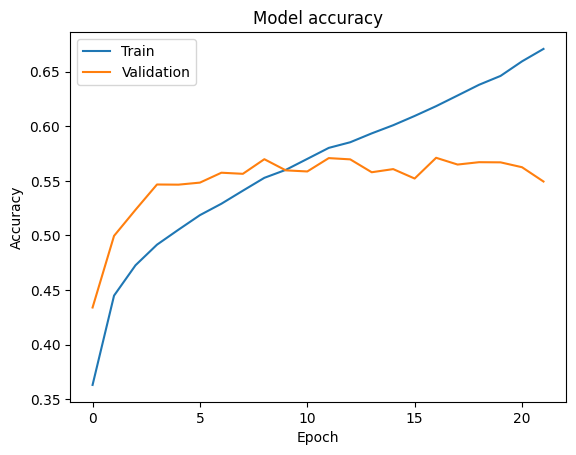

(6955, 1) (6955, 6)


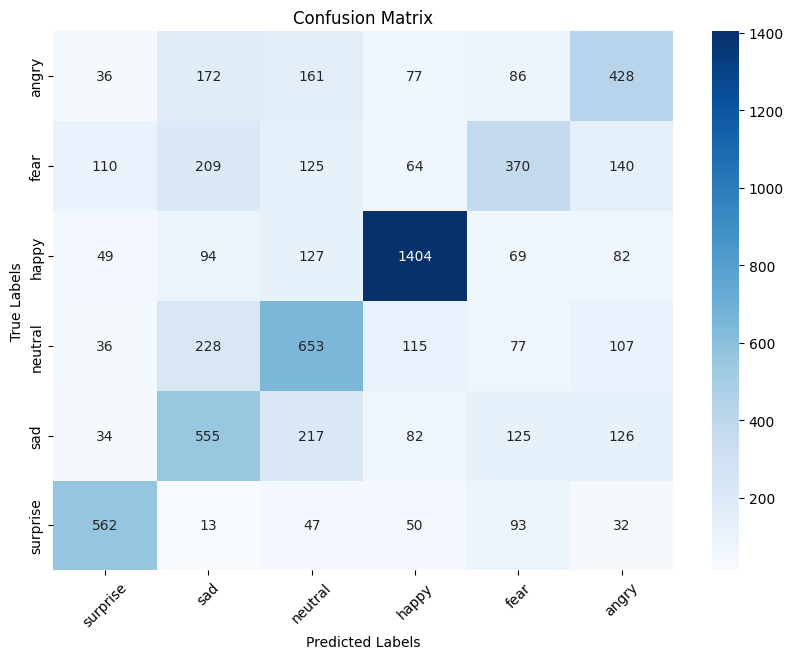

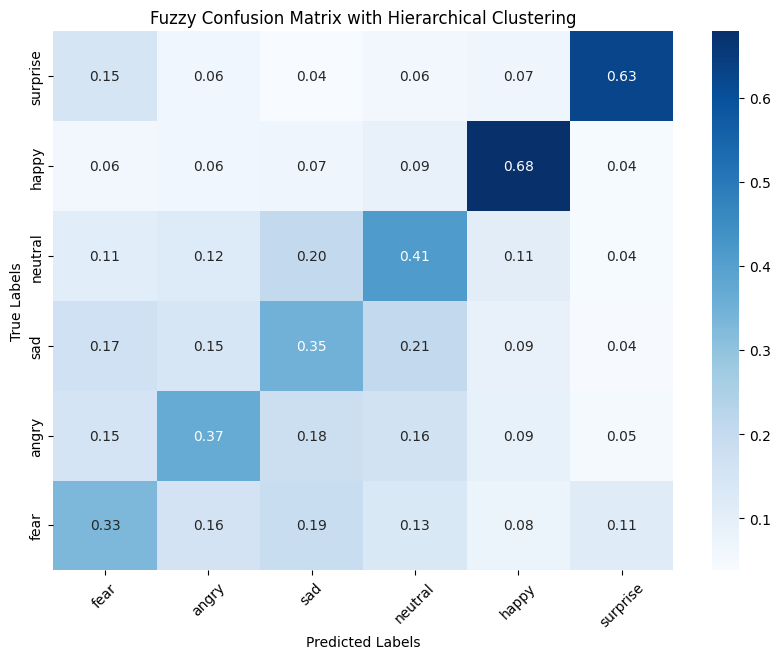

              precision    recall  f1-score   support

       angry       0.47      0.45      0.46       960
        fear       0.45      0.36      0.40      1018
       happy       0.78      0.77      0.78      1825
     neutral       0.49      0.54      0.51      1216
         sad       0.44      0.49      0.46      1139
    surprise       0.68      0.71      0.69       797

    accuracy                           0.57      6955
   macro avg       0.55      0.55      0.55      6955
weighted avg       0.57      0.57      0.57      6955



In [12]:
plot_accuracy(history)

print(y_true.shape, y_pred_probs.shape)

plot_confusion_matrix(y_true, y_pred_probs, class_list)

plot_fuzzy_confusion_matrix(y_true, y_pred_probs)

print(classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_list))

In [56]:
model.save('model_4-2-a.keras')